In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

def flat2d(x):
    x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                     xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
    y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                     xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

In [2]:
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input/','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [3]:
deltat=1800.
ny, nx = 1170, 90

bdir='/work/ollie/mlosch/idemix_test/llc90'
rdir0='/work/ollie/mlosch/idemix_test/llc90/run00'
rdir1='/work/ollie/mlosch/idemix_test/llc90/run01_idemix'
prefix=['diagSeaice']
rname0='CTRL'
rname1='IDEMIX'

In [4]:
ds0 = open_mdsdataset(os.path.join(rdir0),prefix=prefix,
                     delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc')
coords = ds0.coords.to_dataset().reset_coords()
#ds0 = ds0.reset_coords(drop=True)
# We generate the extra metadata needed for multi-faceted grids
# fix coordinates
ds0.coords['XC'] = grid.XC
ds0.coords['YC'] = grid.YC
ds0

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, time: 731)
Coordinates: (12/45)
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    dxV      (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyU      (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF      (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rhoRef   (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-01-01
Data variables:
    SIarea   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIheff   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIhsnow  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIuice   (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIvice   (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [5]:
# ds1 = open_mdsdataset(os.path.join(rdir1),prefix=prefix,
#                      delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc')
# coords = ds1.coords.to_dataset().reset_coords()
# #ds1 = ds1.reset_coords(drop=True)
# # We generate the extra metadata needed for multi-faceted grids
# # fix coordinates
# ds1.coords['XC'] = grid.XC
# ds1.coords['YC'] = grid.YC
ds1=ds0

Text(0.5, 0.98, 'Simulation day 2019-10-01')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
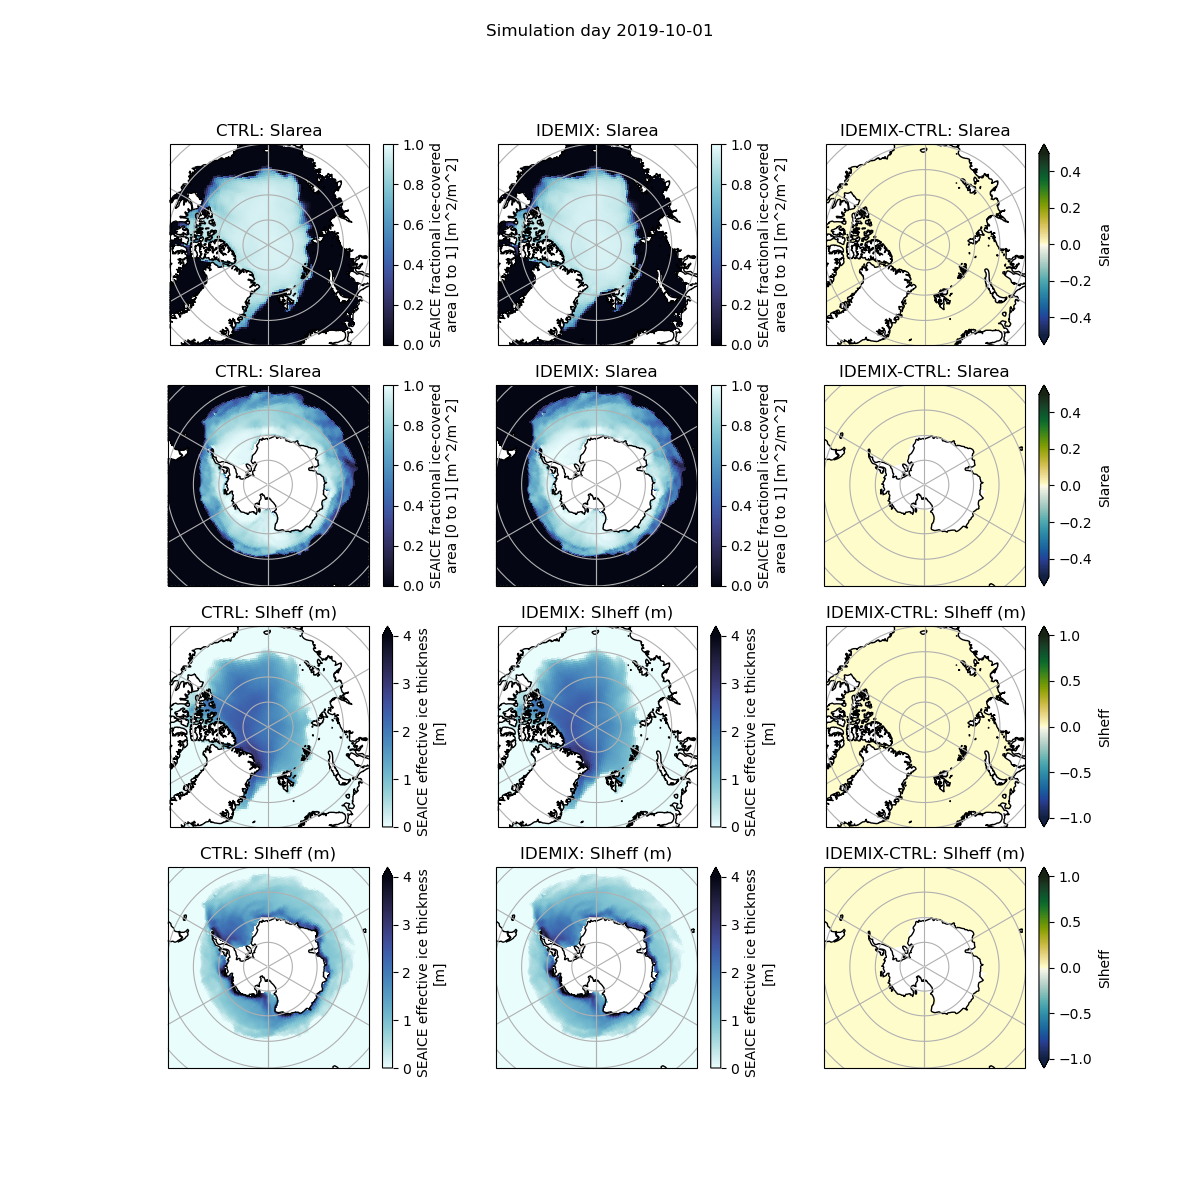

In [17]:
plt.close('all')
mytindex=ds0.time.shape[0]-1
# mytindex=31+28+31 # April 01
# mytindex=31+28+31+30+31+30+31+31+30 # October 01
# mytime=ds0.time.isel(time=mytindex)
mytime=ds0.time.sel(time='2019-04-01')
mytime=ds0.time.sel(time='2019-10-01')

def plot2dmap(ax,ds,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "vertical"}
            if levs.vmin==0. and levs.vmax==1.:
                cbarargs["extend"] = "neither"
            elif levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
#                                             cbar_kwargs={"orientation": "horizontal"},) #, vmin=vmin,vmax=vmax)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()

#proj=cart.crs.Orthographic(-80, 35)#central_longitude=180.0-19) #central_longitude=7.0)
nproj=cart.crs.NorthPolarStereo()
sproj=cart.crs.SouthPolarStereo()

mask2d=ds0.hFacC.isel(k=0)

nextent=[-180, 180, 70, 90]

dd = ds1-ds0
fig = plt.figure(figsize=(12,12))
ax=[]
ax0 = fig.add_subplot(4,3,1, projection=nproj)
plot2dmap(ax0,ds0,ds0.SIarea.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),tstr='%s: SIarea'%rname0,cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,2, projection=nproj)
plot2dmap(ax0,ds1,ds1.SIarea.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),tstr='%s: SIarea'%rname1,cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,3, projection=nproj)
plot2dmap(ax0,ds1,dd.SIarea.sel(time=mytime).where(mask2d!=0.),symNorm(.5),tstr='%s-%s: SIarea'%(rname1,rname0),cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,4, projection=sproj)
plot2dmap(ax0,ds0,ds0.SIarea.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),tstr='%s: SIarea'%rname0,cmap=cmo.ice)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,5, projection=sproj)
plot2dmap(ax0,ds1,ds1.SIarea.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),tstr='%s: SIarea'%rname1,cmap=cmo.ice)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,6, projection=sproj)
plot2dmap(ax0,ds1,dd.SIarea.sel(time=mytime).where(mask2d!=0.),symNorm(vmax=0.5),tstr='%s-%s: SIarea'%(rname1,rname0),cmap=cmo.delta)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,7, projection=nproj)
plot2dmap(ax0,ds0,ds0.SIheff.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),tstr='%s: SIheff (m)'%rname0,cmap=cmo.ice_r)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,8, projection=nproj)
plot2dmap(ax0,ds1,ds1.SIheff.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),tstr='%s: SIheff (m)'%rname1,cmap=cmo.ice_r)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,9, projection=nproj)
plot2dmap(ax0,ds1,dd.SIheff.sel(time=mytime).where(mask2d!=0.),symNorm(vmax=1.),tstr='%s-%s: SIheff (m)'%(rname1,rname0),cmap=cmo.delta)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,10, projection=sproj)
plot2dmap(ax0,ds0,ds0.SIheff.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),tstr='%s: SIheff (m)'%rname0,cmap=cmo.ice_r)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,11, projection=sproj)
plot2dmap(ax0,ds1,ds1.SIheff.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),tstr='%s: SIheff (m)'%rname1,cmap=cmo.ice_r)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(4,3,12, projection=sproj)
plot2dmap(ax0,ds1,dd.SIheff.sel(time=mytime).where(mask2d!=0.),symNorm(vmax=1.),tstr='%s-%s: SIheff (m)'%(rname1,rname0),cmap=cmo.delta)
ax0.set_extent([-180, 180, -90, -50],cart.crs.PlateCarree())
ax.append(ax0)

fig.suptitle('Simulation day %s'%(ds0.time.sel(time=mytime).data.astype('datetime64[D]')))

<xarray.DataArray 'time' ()>
array('2018-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 2018-01-01
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T